# DEFINE SOURCE DIRECTORIES

In [ ]:
SOURCE_DIRECTORY = "/content/drive/MyDrive/icpr/Test_data"
MODEL_DIRECTORY = "mask2former-swin-large-leaf"
results_dir = "results"

# INSTALL DEPENDENCIES

In [ ]:
!pip install transformers albumentations opencv-python datasets==2.15


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x

# LOAD INFERENCE DATA

In [ ]:
import pandas as pd
import numpy as np
import os




images = os.listdir(SOURCE_DIRECTORY)

#filter images with .png extension
images = [img for img in images if img.split('.')[-1] == 'png']



print('Total images:', len(images))


# create dataframe with columns img_no, label, img_path, mask_path
df = pd.DataFrame(columns=['img_no', 'img_path'])
imgNo = 0
for i in range(len(images)):
    img_path = os.path.join(SOURCE_DIRECTORY, images[i])
    tempDict = {'img_no': imgNo,
                'img_path': img_path}
    df = pd.concat([df, pd.DataFrame([tempDict])], ignore_index=True)
    imgNo += 1

#set index to img_no
df.set_index('img_no', inplace=True)
df.to_csv("dataset_validation.csv")

Total images: 68


In [ ]:
import datasets

dataset_csv = "dataset_validation.csv"
dataset_df = pd.read_csv(dataset_csv)
dataset_df.head()

,img_no,img_path
0,0,/content/drive/MyDrive/icpr/Test_data/00211.png
1,1,/content/drive/MyDrive/icpr/Test_data/00203.png
2,2,/content/drive/MyDrive/icpr/Test_data/00207.png
3,3,/content/drive/MyDrive/icpr/Test_data/00208.png
4,4,/content/drive/MyDrive/icpr/Test_data/00212.png


In [ ]:
dataset_df['img_name'] = dataset_df['img_path'].apply(lambda x: x.split(os.sep)[-1])
dataset_df.head()

Dataset({
    features: ['pixel_values', 'img_name'],
    num_rows: 68
})

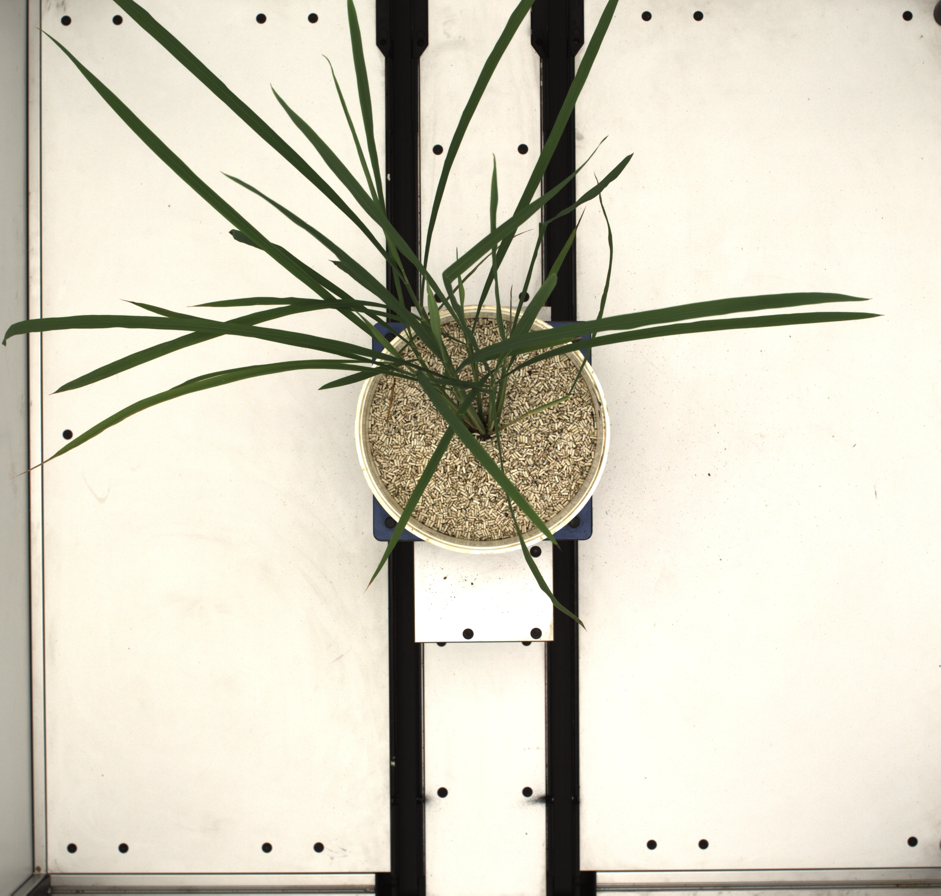

In [ ]:
import os
IMAGES = dataset_df['img_path']
IMG_NAMES = dataset_df['img_name']
for i in range(len(IMAGES)):
    if not os.path.exists(IMAGES[i]):
        print(f"Image: {IMAGES[i]} does not exist")
        raise FileNotFoundError("Image does not exist")


In [ ]:
dataset = datasets.Dataset.from_dict({"pixel_values": IMAGES}, features=datasets.Features({"pixel_values": datasets.Image()}))

In [ ]:
dataset = dataset.add_column("img_name", IMG_NAMES)
dataset

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                     

In [ ]:
dataset[0]['pixel_values']

# INFERENCE

In [ ]:
from transformers import Mask2FormerForUniversalSegmentation
from transformers import MaskFormerImageProcessor
import torch

id2label = {0: "leaf"}
label2id = {"leaf": 0}
model = Mask2FormerForUniversalSegmentation.from_pretrained(MODEL_DIRECTORY, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
processor = MaskFormerImageProcessor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

Processing 68 images
Processing 0/68: 00211.png
pixel_values torch.Size([1, 3, 800, 864])
pixel_mask torch.Size([1, 800, 864])
dict_keys(['segmentation', 'segments_info'])
Saved mask to /content/drive/MyDrive/results/00211.png
Processing 1/68: 00203.png
pixel_values torch.Size([1, 3, 800, 864])
pixel_mask torch.Size([1, 800, 864])
dict_keys(['segmentation', 'segments_info'])
Saved mask to /content/drive/MyDrive/results/00203.png
Processing 2/68: 00207.png
pixel_values torch.Size([1, 3, 800, 864])
pixel_mask torch.Size([1, 800, 864])
dict_keys(['segmentation', 'segments_info'])
Saved mask to /content/drive/MyDrive/results/00207.png
Processing 3/68: 00208.png
pixel_values torch.Size([1, 3, 800, 864])
pixel_mask torch.Size([1, 800, 864])
dict_keys(['segmentation', 'segments_info'])
Saved mask to /content/drive/MyDrive/results/00208.png
Processing 4/68: 00212.png
pixel_values torch.Size([1, 3, 800, 864])
pixel_mask torch.Size([1, 800, 864])
dict_keys(['segmentation', 'segments_info'])
Save

In [ ]:
import numpy as np
import cv2 as cv
from PIL import Image
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * (segment_id+1)).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

## GENERATE OUTPUT

In [ ]:
n_imgs = len(dataset)
print(f"Processing {n_imgs} images")
for i in range(len(dataset)):
    image = dataset[i]["pixel_values"]
    img_name = dataset[i]["img_name"]
    print(f"Processing {i}/{n_imgs}: {img_name}")
    inputs = processor(image, return_tensors="pt").to(device)
    for k,v in inputs.items():
      print(k,v.shape)
    with torch.no_grad():
      outputs = model(**inputs)
    results = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    print(results.keys())
    fmask = None
    for segment in results['segments_info']:
        # print("Visualizing mask for instance:", model.config.id2label[segment['label_id']])
        mask = get_mask(results['segmentation'], segment['id'])
        if fmask is None:
          fmask = np.array(mask)
        fmask = cv.bitwise_or(fmask, np.array(mask))
        # display(mask)
    outPath = os.path.join(results_dir, img_name)
    cv.imwrite(outPath, fmask)
    print(f"Saved mask to {outPath}")